In [2]:
from mpl_toolkits.mplot3d import Axes3D
from numpy import *
from scipy.integrate import solve_ivp
import matplotlib; 
from matplotlib.pyplot import *
import seaborn as sns
sns.set()
%matplotlib notebook
import time

# Euler explicite à pas variable

La fonction suivante code un schéma d'Euler explicite à pas variable : l'erreur commise est estimée à chaque itération et le pas de temps adapté de façon à garder cette erreur en dessous d'un seuil. Le pas reste compris entre dtmin et dtmax fixés par l'utilisateur et sort la solution échantillonnée à dtmax. Vous devrez comprendre le fonctionnement de cette méthode et l'illustrer dans votre projet numérique.

In [3]:
def solve_ivp_euler_explicit_variable_step(f, t0, x0, t_f, dtmin = 1e-16, dtmax = 0.01, atol = 1e-6):
    dt = dtmax/10; # initial integration step
    ts, xs = [t0], [x0]  # storage variables
    t = t0
    ti = 0  # internal time keeping track of time since latest storage point : must remain below dtmax
    x = x0
    while ts[-1] < t_f:
        while ti < dtmax:
            t_next, ti_next, x_next = t + dt, ti + dt, x + dt * f(x)
            x_back = x_next - dt * f(x_next)
            ratio_abs_error = atol / (linalg.norm(x_back-x)/2)  
            dt = 0.9 * dt * sqrt(ratio_abs_error)
            if dt < dtmin:
                raise ValueError("Time step below minimum")
            elif dt > dtmax/2:
                dt = dtmax/2
            t, ti, x = t_next, ti_next, x_next
        dt2DT = -dtmax + ti # time left to dtmax
        t_next, ti_next, x_next = t + dt2DT, 0, x + dt2DT * f(x)
        ts = vstack([ts,t_next])
        xs = vstack([xs,x_next])
        t, ti, x = t_next, ti_next, x_next
    return (ts, xs.T)

# Commentaires

* l'erreur locale est approchée par la formule trouvée $\displaystyle \lVert e^{j+1} \rVert \approx  \frac{\Delta t_j}{2} \lVert f(t_{j+1}, x^{j+1})-f(t_j, x^j)\rVert $ car x_back-x = dt*(f(x)-f(x + dtf(x)))
* on impose ensuite (selon la question d'après sur le $\Delta t_{new}$) une nouvelle valeur de dt adaptée à cette itération en le diminiuant (*0.9) pour garder une marge de sécurité 
* si dt est encore trop grand (> dtmax/2), on le diminue encore et s'il est trop petit cela interrompt le programme pour éviter les erreurs d'arrondi
* la boucle while interne sert à calculer par la formule du schéma d'Euler explicite, le pas de temps restant $dt2DT$ qui est par définition suffisement faible pour ne pas générer une erreur supérieure à $Tol_{abs}$
* J'ai fait un troisième notebook intitulé "Solveur bis" où j'ai tout recopié en supprimant juste la boucle while interne de ce premier programme et le ti : j'ai obtenu les mêmes courbes donc la boucle while interne sert juste à avoir une solution échantillonnée à dtmax à la sortie
* le reste est une fonction euler classique

Par exemple, sur un oscillateur, le pas de temps "interne" s'adapte automatiquement à la pulsation $\omega$. Notons que la solution en sortie est toujours échantillonnées à dtmax, donc il faut diminuer ce paramètre si l'on veut plus de précision de visualisation.

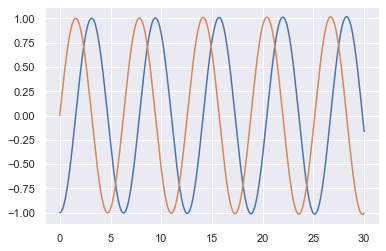

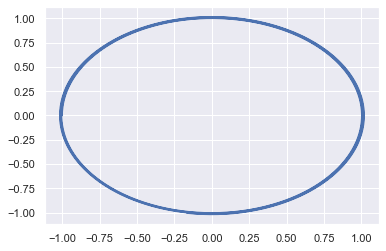

In [10]:
# Oscillateur 

omega = 1

def f(xy):
    x, y = xy
    return array([y, -omega*x])

t0, tf, x0 = 0.0, 30.0, array([-1.0, 0.0])

t, x = solve_ivp_euler_explicit_variable_step(f, t0, x0, tf)

figure()
plot(t, x[0])
plot(t, x[1])
grid(True)

figure()
plot(x[0],x[1])


On constate cependant que les solutions ne suivent pas une ellipse parfaite car l'énergie n'est pas conservée par l'algorithme. Pour ce type de système conservatif, il faudrait en fait un schéma symplectique. Voir plus bas.

# Système raide

Les systèmes raides désignent des systèmes comprenant des dynamiques aux constantes de temps très différentes. Dans ce cas, le pas nécessaire pour simuler avec précision les dynamiques très rapides est si petit, qu'il est alors impossible de simuler assez longtemps pour observer les parties lentes. La particularité de ces systèmes est que cette décroissance du pas apparaît alors que la solution est parfaitement régulière, et non pas proche de singularités.

La coexistence de dynamiques très lentes à très rapides apparaît typiqument en cinétique chimique, par exemple la réaction de Robertson : $\begin{align} A & \stackrel{0.04}{\longrightarrow} B \quad \text{(lente)} \ B + B & \stackrel{3 \times 10^7}{\longrightarrow} B + C \quad \text{(très rapide)} \ B + C & \stackrel{10^4}{\longrightarrow} A + C \quad \text{(rapide)} \end{align}$ modélisée par $\begin{align} \dot{x}_a &= -0.04 x_b + 10^4 x_bx_c \ \dot{x}_b &= 0.04 x_a - 10^4 x_bx_c - 3\times 10^7 x_b^2\ \dot{x}_c &= 3\times 10^7 x_b^2 \end{align} $

Lorsqu'on applique le schéma d'Euler explicite à pas variable, le compromis précision/pas de temps devient impossible.

In [11]:
def f(xabc):
    xa, xb, xc = xabc
    return array([-0.04 * xb + 1e4 * xb * xc, 0.04 * xa - 1e4 * xb * xc - 3e7 * xb**2,  3e7 * xb**2])

t0, tf, x0 = 0.0, 5.0, array([1.0, 0.0, 0.0])

t, x = solve_ivp_euler_explicit_variable_step(f, t0, x0, tf, dtmin = 1e-20, atol = 1)

figure()
plot(t, x[0])
plot(t, x[1])
plot(t, x[2])
grid(True)


ValueError: Time step below minimum

# Système hamiltonien : exemple d'un problème à deux corps
Voir exercice "Euler Symplectique"

In [12]:
e = 0.01
q0 = array([1-e,0.0])
p0 = array([0.0,sqrt((1+e)/(1-e))])
t0, tf, dt = 0.0 , 50.0, 0.01

In [13]:
def solve_ivp_euler_symplectic(fp, fq, t0, q0, p0, dt, tf):
    """on utilise le schéma euler symplectique vu en exo sans adapter le pas de temps"""
    ts, qs, ps = [t0], [q0], [p0]
    while ts[-1] < tf:
        t, q, p = ts[-1], qs[-1], ps[-1]
        t_next, q_next = t + dt, q + dt * fq(p)
        p_next = p + dt * fp(q_next)
        ts = vstack([ts, t_next])
        qs = vstack([qs, q_next])
        ps = vstack([ps, p_next])
    return (ts, qs.T, ps.T)

In [14]:
# sytème hamiltoninen (cf. début du poly)

def fq(p):
    return p

def fp(q):
    q1, q2 = q
    return array([-q1/power(q1**2+q2**2,3/2),-q2/power(q1**2+q2**2,3/2)])

def fun(qp):
    q1, q2, p1, p2 = qp
    return concatenate([fq([p1,p2]),fp([q1,q2])])

Text(0.5, 1.0, 'Euler explicite pas variable')

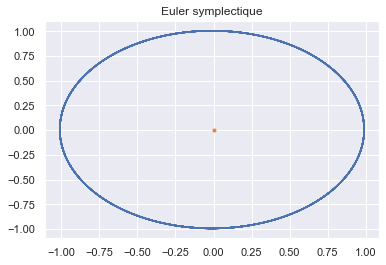

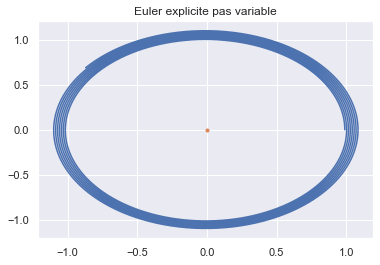

In [15]:
t, q, p = solve_ivp_euler_symplectic(fp, fq, t0, q0, p0, dt, tf)

t, qp = solve_ivp_euler_explicit_variable_step(fun, t0, concatenate([q0,p0]), tf)

figure()
plot(q[0], q[1])
plot([0.0],[0.0],'.')
grid(True)
title('Euler symplectique')

figure()
plot(qp[0],qp[1])
plot([0.0],[0.0],'.')
grid(True)
title('Euler explicite pas variable')